<a href="https://colab.research.google.com/github/ChetanSarda99/FineTuned_SQL_LLM/blob/main/Dataset_Creation_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

High-quality data is fundamental to produce a good model. The higher the quality, the better the model. In this notebook, we will create a dataset for fine-tuning LLMs.

![](https://i.imgur.com/IDNhAWH.png)

There are different types of datasets we can use to fine-tune LLMs:

1. **Instruction datasets**: inputs are instructions (e.g., questions) and outputs correspond to the expected responses (e.g., answers). *Example: Open-Orca.*
2. **Raw completion**: this is a continuation of the pre-training objective (next token prediction). In this case, the trained model is not designed to be used as an assistant. *Example: MADLAD-400.*
3. **Preference datasets**: these datasets are used with reinforcement learning to rank candidate responses. They can provide multiple answers to the same instruction, and help the model to select the best response. *Example: ultrafeedback_binarized.*
4. **Others**: a fill-in-the-middle objective is very popular with code completion models (e.g., Codex from GitHub Copilot). Other datasets can be designed for classification, where the outputs correspond to the labels we want to predict (the model requires an additional classfication head in this case).

In practice, supervised fine-tuning only leverages the first type of dataset. We can either **create our own** instruction dataset or **modify an existing one** to filter, improve, or enrich it.


In [ ]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("goendalf666/sql_instructions")
dataset

DatasetDict({
    train: Dataset({
        features: ['training_input'],
        num_rows: 78577
    })
})

In [ ]:
# Read as pandas DataFrame
df = dataset['train'].to_pandas()

,training_input
0,###context:CREATE TABLE head (age INTEGER)\n ...
1,"###context:CREATE TABLE head (name VARCHAR, bo..."
2,###context:CREATE TABLE department (creation V...
3,###context:CREATE TABLE department (budget_in_...
4,###context:CREATE TABLE department (num_employ...
...,...
78572,###context:CREATE TABLE table_name_35 (time VA...
78573,###context:CREATE TABLE table_name_83 (ground ...
78574,###context:CREATE TABLE table_name_60 (competi...
78575,###context:CREATE TABLE table_name_34 (decile ...


In [ ]:
df['training_input'][0]

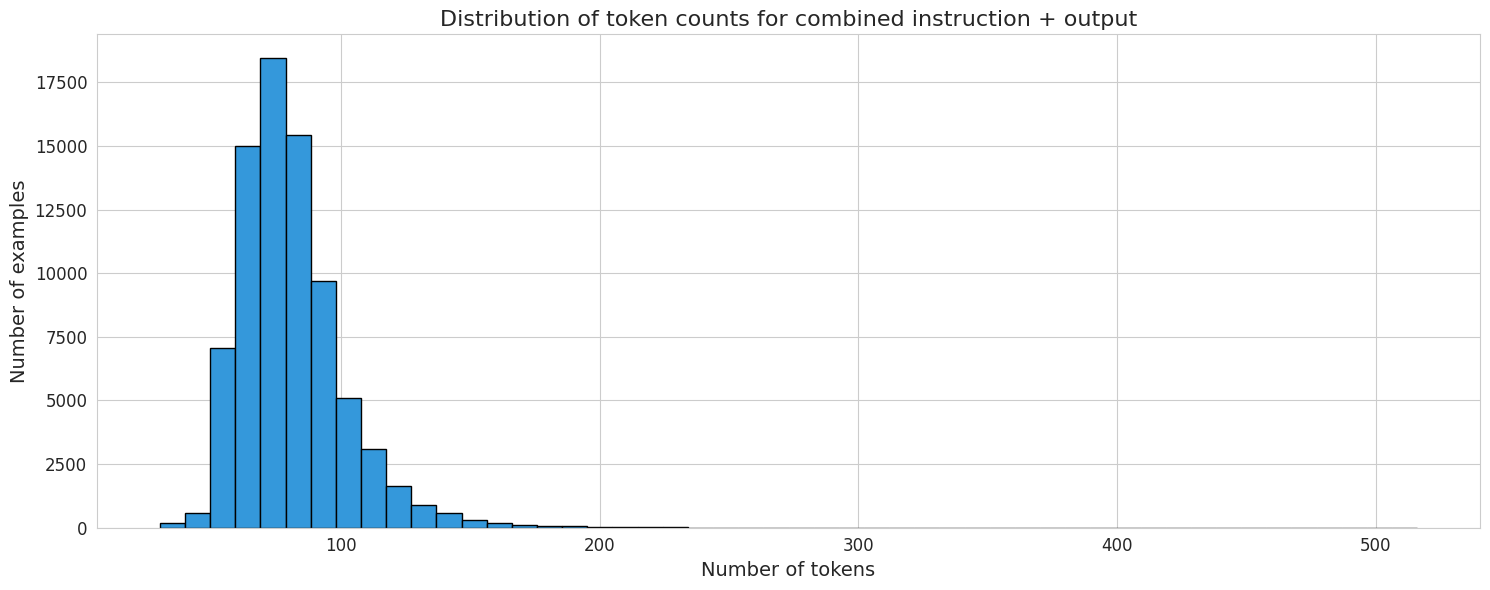

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
token_counts = [len(tokenizer.tokenize(example["training_input"])) for example in dataset['train']]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# Read as pandas DataFrame
df = dataset['train'].to_pandas()
df['training_input'][0]

'###context:CREATE TABLE head (age INTEGER)\n    ###human: How many heads of the departments are older than 56 ?\n    ###assistant: SELECT COUNT(*) FROM head WHERE age > 56'

In [ ]:
'''def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)'''

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Push to Hugging Face Hub
dataset.push_to_hub("ChetanSarda99/SQL-finetune", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/79 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ChetanSarda99/SQL-finetune/commit/8130386eea52acbed08b9725f57d14eb5aac504a', commit_message='Upload dataset', commit_description='', oid='8130386eea52acbed08b9725f57d14eb5aac504a', pr_url=None, pr_revision=None, pr_num=None)